# Kaggle: Zillow Housing Ridge Regression with MICE

In [1]:
#######################################
### Import Data Processing Packages ###
#######################################

import pandas            as pd;
import numpy             as np;
import seaborn           as sns;
import matplotlib.pyplot as plt;
import math              as math;

import gc

import csv

from time import time

%matplotlib inline

from scipy import stats;

########################################
### Import Machine Learning Packages ###
########################################

from sklearn.preprocessing   import StandardScaler;
from sklearn.preprocessing   import PolynomialFeatures;

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV;
from sklearn.metrics         import classification_report, confusion_matrix, mean_absolute_error, mean_squared_error;

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis;
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis;

from sklearn.linear_model    import LinearRegression;
from sklearn.linear_model    import LogisticRegression, LogisticRegressionCV;
from sklearn.linear_model    import Ridge, RidgeCV;
from sklearn.linear_model    import Lasso, LassoCV;
from sklearn.linear_model    import ElasticNet, ElasticNetCV;
from sklearn.linear_model    import SGDRegressor;
from sklearn.linear_model    import Lars;
from sklearn.linear_model    import LassoLars;
from sklearn.linear_model    import OrthogonalMatchingPursuit;
from sklearn.linear_model    import BayesianRidge;

from sklearn.neighbors       import KNeighborsClassifier;
from sklearn.tree            import DecisionTreeClassifier;
from sklearn.ensemble        import RandomForestClassifier;
from sklearn.svm             import SVR;
from sklearn.cluster         import KMeans;
from sklearn.decomposition   import PCA;

from sklearn.ensemble        import RandomForestRegressor;
from sklearn.ensemble        import GradientBoostingRegressor;
from sklearn.ensemble        import AdaBoostRegressor;

from sklearn.neural_network  import MLPClassifier;

from sklearn.pipeline        import Pipeline;

from statsmodels.imputation  import mice

In [39]:
print('Loading data ...')

names = ['parcelid', 'air_conditioning_type', 'architectural_style', 
         'area_basement', 'num_bathroom', 'num_bedroom', 'framing_type',
         'building_quality', 'num_bathroom_calc', 'deck_type',
         'area_firstfloor_finished', 'area_total_calc',
         'area_living_finished', 'perimeter_living',
         'area_total', 'area_firstfloor_unfinished',
         'area_base', 'fips', 'num_fireplace', 'num_fullbath',
         'num_garagecar', 'area_garage', 'hashottuborspa',
         'heating_type', 'latitude', 'longitude',
         'area_lot', 'num_pool', 'area_pools', 'pooltypeid10',
         'pooltypeid2', 'pooltypeid7', 'property_land_use_code',
         'property_land_use_type', 'property_zoning_desc',
         'census_raw_tract_block', 'region_city', 'region_county',
         'region_neighborhood', 'region_zipcode', 'num_room', 'story_type',
         'num_34_bath', 'material_type', 'num_unit',
         'area_patio', 'area_shed', 'build_year',
         'num_stories', 'flag_fireplace', 'tax_assessed_structure_value',
         'tax_assessed_parcel_value', 'tax_assessment_year', 'tax_assessed_land_alue',
         'tax_property', 'tax_delinquency_flag', 'tax_delinquency_year',
         'census_tract_block']

train  = pd.read_csv('train_2016_v2.csv')
prop   = pd.read_csv('properties_2016.csv', names=names, header=0)
sample = pd.read_csv('sample_submission.csv')

print('Binding to float32')

for c, dtype in zip(prop.columns, prop.dtypes):
    if dtype == np.float64:
        prop[c] = prop[c].astype(np.float32)
        
print(np.shape(train))
print(np.shape(prop))
print(np.shape(sample))

Loading data ...


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Binding to float32
(90275, 3)
(2985217, 58)
(2985217, 7)


In [40]:
print('Creating training set ...')

df_train = train.merge(prop, how='left', on='parcelid')
y_train  = df_train['logerror'].values
df_train = df_train.drop(['logerror', 'transactiondate'], axis=1)

print(np.shape(df_train))

print('Creating testing set ...')

sample['parcelid'] = sample['ParcelId'];
sample = sample.drop(['ParcelId', '201610', '201611', '201612', '201710', '201711', '201712'], axis=1)
df_sample = pd.merge(sample, prop, on='parcelid', how='left')

print(np.shape(df_sample))

del train, prop, sample;
gc.collect();

Creating training set ...
(90275, 58)
Creating testing set ...
(2985217, 58)


In [41]:
df_train = df_train.drop(['census_raw_tract_block', 'census_tract_block', 'region_city', 'region_neighborhood', 'region_zipcode'], 
                     axis=1);

df_sample = df_sample.drop(['census_raw_tract_block', 'census_tract_block', 'region_city', 'region_neighborhood', 'region_zipcode'], 
                     axis=1);

print(np.shape(df_train))
print(np.shape(df_sample))

(90275, 53)
(2985217, 53)


In [42]:
######################################################################
### Replace Columns with Lots of NaN values with NaN Value Columns ###
######################################################################

df_train_nan = df_train.isnull().sum(axis=0)/len(df_train);

df_train[df_train_nan[df_train_nan > 0.9].index.values]  = df_train[df_train_nan[df_train_nan > 0.9].index.values].notnull().astype('int')
df_sample[df_train_nan[df_train_nan > 0.9].index.values] = df_sample[df_train_nan[df_train_nan > 0.9].index.values].notnull().astype('int')

print(np.shape(df_train))
print(np.shape(df_sample))

(90275, 53)
(2985217, 53)


In [43]:
print('Merging training and testing for preprocessing...')

assert(np.array_equal(df_train.columns.values, df_sample.columns.values))

rows_train = np.shape(df_train)[0]
df_all = pd.concat([df_train, df_sample])

print(np.shape(df_all))

del df_train, df_sample;
gc.collect();

Merging training and testing for preprocessing...
(3075492, 53)


In [44]:
df_all = pd.concat([df_all, pd.get_dummies(df_all['fips'],                prefix='fips',                dummy_na=True)], axis=1);
df_all = pd.concat([df_all, pd.get_dummies(df_all['heating_type'],        prefix='heating_type',        dummy_na=True)], axis=1);
df_all = pd.concat([df_all, pd.get_dummies(df_all['region_county'],       prefix='region_county',       dummy_na=True)], axis=1);
df_all = pd.concat([df_all, pd.get_dummies(df_all['tax_assessment_year'], prefix='tax_assessment_year', dummy_na=True)], axis=1);

df_all = df_all.drop('fips',                  axis=1);
df_all = df_all.drop('heating_type',          axis=1);
df_all = df_all.drop('region_county',         axis=1);
df_all = df_all.drop('tax_assessment_year',   axis=1);

print(np.shape(df_all))

(3075492, 87)


In [45]:
df_prop = df_all[['property_zoning_desc', 'property_land_use_type', 'property_land_use_code']]

df_all = df_all.drop(['property_zoning_desc', 'property_land_use_type', 'property_land_use_code'], axis=1)

In [ ]:
df_train  = df_all[:rows_train]
df_sample = df_all[rows_train:]

del df_all;
gc.collect();

print(np.shape(df_train))
print(np.shape(df_sample))

(90275, 84)
(2985217, 84)


In [ ]:
# Drop Columns that have all zero entries
'''
for col in df_train.columns[(df_train == 0).all()].values:
    df_train.drop(col,  axis=1);
    df_sample.drop(col, axis=1);

for col in df_sample.columns[(df_sample == 0).all()].values:
    df_train.drop(col,  axis=1);
    df_sample.drop(col, axis=1);
'''

In [ ]:
df_train  = df_train.rename( columns = lambda x : str(x).replace('.', '_'))
df_sample = df_sample.rename(columns = lambda x : str(x).replace('.', '_'))

df_train  = df_train.rename( columns = lambda x : str(x).replace('*', '_'))
df_sample = df_sample.rename(columns = lambda x : str(x).replace('*', '_'))

df_sample = df_sample.rename(columns = lambda x : str(x).replace('0', 'zero'))
df_sample = df_sample.rename(columns = lambda x : str(x).replace('1', 'one'))
df_sample = df_sample.rename(columns = lambda x : str(x).replace('2', 'two'))
df_sample = df_sample.rename(columns = lambda x : str(x).replace('3', 'three'))
df_sample = df_sample.rename(columns = lambda x : str(x).replace('4', 'four'))
df_sample = df_sample.rename(columns = lambda x : str(x).replace('5', 'five'))
df_sample = df_sample.rename(columns = lambda x : str(x).replace('6', 'six'))
df_sample = df_sample.rename(columns = lambda x : str(x).replace('7', 'seven'))
df_sample = df_sample.rename(columns = lambda x : str(x).replace('8', 'eight'))
df_sample = df_sample.rename(columns = lambda x : str(x).replace('9', 'nine'))

df_train = df_train.rename(columns = lambda x : str(x).replace('0', 'zero'))
df_train = df_train.rename(columns = lambda x : str(x).replace('1', 'one'))
df_train = df_train.rename(columns = lambda x : str(x).replace('2', 'two'))
df_train = df_train.rename(columns = lambda x : str(x).replace('3', 'three'))
df_train = df_train.rename(columns = lambda x : str(x).replace('4', 'four'))
df_train = df_train.rename(columns = lambda x : str(x).replace('5', 'five'))
df_train = df_train.rename(columns = lambda x : str(x).replace('6', 'six'))
df_train = df_train.rename(columns = lambda x : str(x).replace('7', 'seven'))
df_train = df_train.rename(columns = lambda x : str(x).replace('8', 'eight'))
df_train = df_train.rename(columns = lambda x : str(x).replace('9', 'nine'))

df_train  = df_train.rename( columns = lambda x : str(x).replace('_', ''))
df_sample = df_sample.rename(columns = lambda x : str(x).replace('_', ''))

df_train.columns  = df_train.columns.astype(str)
df_sample.columns = df_sample.columns.astype(str)
    
imp_train  = mice.MICEData(df_train)
imp_sample = mice.MICEData(df_sample)

imp_train.update_all()
imp_sample.update_all()

df_train  = imp_train.data;
df_sample = imp_sample.data;

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\imputation\mice.py:972: RuntimeWarning: covariance is not positive-semidefinite.
  self.params[vname] = np.random.multivariate_normal(mean=mu, cov=cov)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [ ]:
print('Merging training and testing for preprocessing...')

assert(np.array_equal(df_train.columns.values, df_sample.columns.values))

rows_train = np.shape(df_train)[0]
df_all = pd.concat([df_train, df_sample])

print(np.shape(df_all))

del df_train, df_sample;
gc.collect();

Merging training and testing for preprocessing...
(3075492, 84)


In [ ]:
print(np.shape(df_all))
print(np.shape(df_prop))

(3075492, 84)
(3075492, 3)


In [ ]:
df_all = pd.concat([df_all, df_prop], axis=1)

zoning_counts        = df_all['property_zoning_desc'].value_counts().reset_index();
land_use_type_counts = df_all['property_land_use_type'].value_counts().reset_index();
land_use_code_counts = df_all['property_land_use_code'].value_counts().reset_index();

df_all['property_zoning_desc']   = df_all['property_zoning_desc'].replace(  to_replace=zoning_counts[zoning_counts['property_zoning_desc']                 < 1000]['index'].values, value='zone_other')
df_all['property_land_use_type'] = df_all['property_land_use_type'].replace(to_replace=land_use_type_counts[land_use_type_counts['property_land_use_type'] < 1000]['index'].values, value='landtype_other')
df_all['property_land_use_code'] = df_all['property_land_use_code'].replace(to_replace=land_use_code_counts[land_use_code_counts['property_land_use_code'] < 1000]['index'].values, value='landuse_other')

df_all = pd.concat([df_all, pd.get_dummies(df_all['property_zoning_desc'],   prefix='zoning')],   axis=1);
df_all = pd.concat([df_all, pd.get_dummies(df_all['property_land_use_type'], prefix='landtype')], axis=1);
df_all = pd.concat([df_all, pd.get_dummies(df_all['property_land_use_code'], prefix='landcode')], axis=1);

df_all = df_all.drop('property_zoning_desc',   axis=1);
df_all = df_all.drop('property_land_use_type', axis=1);
df_all = df_all.drop('property_land_use_code', axis=1);

print(np.shape(df_all))

(3075492, 453)


In [ ]:
df_train  = df_all[:rows_train]
df_sample = df_all[rows_train:]

del df_all;
gc.collect();

print(np.shape(df_train))
print(np.shape(df_sample))

(90275, 453)
(2985217, 453)


In [ ]:
###############
### Scaling ###
###############

train_scaler = StandardScaler();
train_scaler.fit(df_train.drop('parcelid', axis=1));
df_train = train_scaler.transform(df_train.drop('parcelid', axis=1));

test_scaler = StandardScaler();
test_scaler.fit(df_sample.drop('parcelid', axis=1));
df_sample = test_scaler.transform(df_sample.drop('parcelid', axis=1));

print(np.shape(df_train))
print(np.shape(df_sample))

(90275, 452)
(2985217, 452)


In [ ]:
### Export As CSV to Save Time Later

print(np.shape(df_train))
print(np.shape(df_sample))

print('Writing csv ...') 
np.savetxt("input/Train_MICE_Expanded_Scaled_p4.csv", df_train,  delimiter=",", fmt='%1.4f')
np.savetxt("input/Test_MICE_Expanded_Scaled_p4.csv",  df_sample, delimiter=",", fmt='%1.4f')

(90275, 452)
(2985217, 452)
Writing csv ...


In [5]:
### Load CSV
'''
df_train  = np.loadtxt('Train_MedianImpute_Scaled_p4.csv', delimiter=',')
df_sample = np.loadtxt('Test_MedianImpute_Scaled_p4.csv',  delimiter=',')

print(np.shape(df_train))
print(np.shape(df_sample))

'''

In [ ]:
#x_train = df_train.drop(['parcelid'], axis=1)
x_train = df_train
print(x_train.shape, y_train.shape)

#train_columns = x_train.columns

#for c in x_train.dtypes[x_train.dtypes == object].index.values:
#    x_train[c] = (x_train[c] == True)
#    
#x_train.head()

(90275, 452) (90275,)


In [ ]:
x_train2, x_valid2, y_train2, y_valid2 = train_test_split(x_train, y_train, test_size=0.2)

print(x_train2.shape, y_train2.shape)
print(x_valid2.shape, y_valid2.shape)

#del df_train; gc.collect()

(72220, 452) (72220,)
(18055, 452) (18055,)


In [ ]:
print(mean_absolute_error(y_valid2, np.zeros(len(y_valid2))))
print(mean_absolute_error(y_valid2, np.full(len(y_valid2), np.mean(y_valid2))))

0.0686423705345
0.0688144901054


In [ ]:
lr = Ridge(alpha=10**5)

print('Training ...')

start_time = time();
lr.fit(x_train2, y_train2);
pred1 = lr.predict(x_valid2);
print("Fitting and training took " + str(time()-start_time) + " s")

start_time = time();
pred2 = cross_val_predict(lr, x_train, y_train, cv=5)
print("Cross-val predict took " + str(time()-start_time) + " s")

fig  = plt.figure(figsize=(8, 3), dpi=100);

axes1 = fig.add_subplot(121); 
axes1.scatter(y_valid2, pred1, c='orange', s=20)
axes1.set_title("Train Test Split")
axes1.set_xlabel('Measured')
axes1.set_ylabel('Predicted')

axes2 = fig.add_subplot(122); 
axes2.scatter(y_train, pred2, c='orange', s=20)
axes2.set_title("Cross Validation")
axes2.set_xlabel('Measured')
axes2.set_ylabel('Predicted')

fig.tight_layout();

print("Train Test Split")
print('MAE:',          mean_absolute_error(y_valid2, pred1))
print('MSE:',          mean_squared_error( y_valid2, pred1))
print('RMSE:', np.sqrt(mean_squared_error( y_valid2, pred1)))
print('\n')
print("Cross Validation")
print('MAE:',          mean_absolute_error(y_train, pred2))
print('MSE:',          mean_squared_error( y_train, pred2))
print('RMSE:', np.sqrt(mean_squared_error( y_train, pred2)))

#del d_train, d_valid

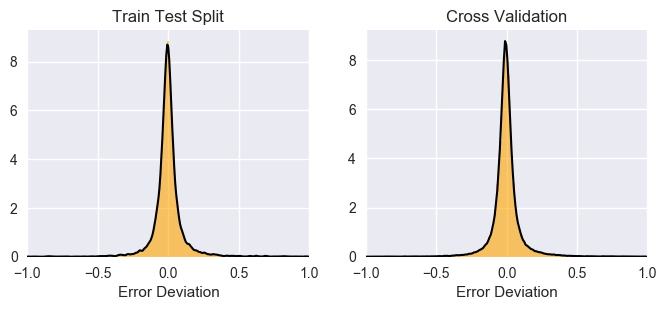

In [ ]:
fig  = plt.figure(figsize=(8, 3), dpi=100);

axes1 = fig.add_subplot(121); 
axes2 = fig.add_subplot(122); 

sns.distplot((y_valid2-pred1), bins=500, ax=axes1, axlabel='Error Deviation', kde_kws={"color": "k", "lw": 1.5, "gridsize":1000}, hist_kws={"linewidth": 3, "alpha": 0.6, "color": "orange"});
sns.distplot((y_train -pred2), bins=500, ax=axes2, axlabel='Error Deviation', kde_kws={"color": "k", "lw": 1.5, "gridsize":1000}, hist_kws={"linewidth": 3, "alpha": 0.6, "color": "orange"});

axes1.set_title("Train Test Split")
axes2.set_title("Cross Validation")

axes1.set_xlim(-1, 1);
axes2.set_xlim(-1, 1);

[ -1.14467699e-02  -1.09915631e-02  -8.40881011e-03  -1.78016958e-03
  -7.30268185e-05   1.18386514e-04   4.62386259e-04   7.74850852e-04
   1.13004418e-03   2.45936828e-03   3.29523148e-04  -7.07428784e-04]


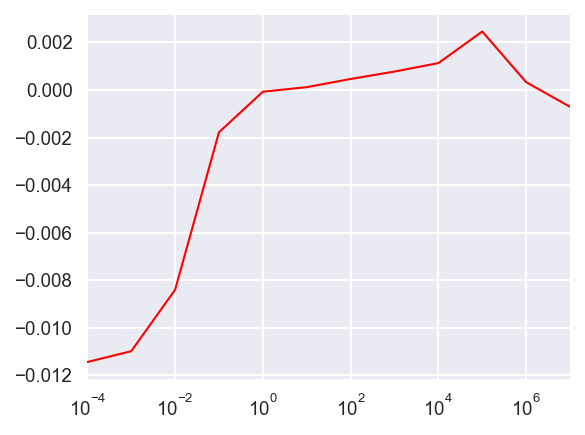

In [ ]:
lr = Ridge()

values = [10.0**power for power in np.arange(-4, 8, 1)]

param_grid = [{'alpha': values}]
grid = GridSearchCV(lr, param_grid, cv=5)
grid.fit(x_train, y_train)
print(grid.cv_results_['mean_test_score'])
grid.best_estimator_

fig = plt.figure(figsize=(4, 3), dpi=150);
axes1 = fig.add_subplot(111); 
axes1.plot(values, grid.cv_results_['mean_test_score'],  color='red',  linewidth = 1);
axes1.axis('tight');
axes1.tick_params(axis = 'both', which = 'major', labelsize = 9);#
axes1.set_xscale('log')
#axes1.set_yscale('log')
axes1.set_xbound(min(values), max(values))
fig.tight_layout();

In [ ]:
print('Exporting Train Predictions for Stacking');

pred_train = lr.predict(x_train);

np.savetxt("pred_train/17_07_04_Ridge_MICE_Expanded.csv", pred_train,  delimiter=",", fmt='%1.4f')

In [ ]:
print('Building test set ...')

#df_test = df_sample.drop('parcelid', axis=1)
df_test = df_sample

print(np.shape(df_test))

In [ ]:
#x_test = df_test[df_test.columns.values]
x_test = df_test

#print(len(x_test.columns.values))
#print(len(x_test.columns.unique()))

#del df_test, sample; gc.collect()

In [ ]:
print('Predicting on test ...')

p_test = lr.predict(x_test)

#del d_test; gc.collect()

sub = pd.read_csv('sample_submission.csv')
for c in sub.columns[sub.columns != 'ParcelId']:
    sub[c] = p_test

In [ ]:
print('Writing csv ...')
sub.to_csv('pred_test/17_07_04_Ridge_MICE_Expanded.csv',   index=False, float_format='%.4f')
sub.to_csv('submissions/17_07_04_Ridge_MICE_Expanded.csv', index=False, float_format='%.4f')